# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()


## Load Data

In [4]:
# Load the data file
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


In [5]:
# Print general information about 'df_reviews'
df_reviews.info()
df_reviews.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [6]:
# Print a sample of the data for 'df_reviews'
df_reviews.sample(5)


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
17137,tt0397065,movie,House of Wax,House of Wax,2005,\N,113,0,"Horror,Thriller",5.3,112969,"Ignore the extreme votes about ""House of Wax"",...",4,neg,0,test,926
42632,tt0108473,movie,The Vanishing,The Vanishing,1993,\N,109,0,"Drama,Horror,Mystery",6.3,22602,"Skip this Hollywood version, a real piece of g...",1,neg,0,test,8636
14855,tt0432047,movie,Government,Sarkar,2005,\N,124,0,"Action,Crime,Drama",7.6,15262,A remake can be successful. An adaptation can ...,2,neg,0,test,12487
46031,tt0455857,movie,When a Stranger Calls,When a Stranger Calls,2006,\N,87,0,"Horror,Thriller",5.1,42142,"All you need is great house, a babysitter and ...",8,pos,1,test,11405
3420,tt0080391,movie,Attack of the Killer Tomatoes!,Attack of the Killer Tomatoes!,1978,\N,83,0,"Adventure,Comedy,Horror",4.6,12181,The easiest way to describe this movie is as a...,3,neg,0,train,7719


The features that are necessary for the analysis below ('review', 'pos', and 'ds_part') do not have any missing values that need to be addressed. However, the 'review' feature contains both lower and uppercase letters as well as a variety of punctuation which indicates a need to standardize the text.

## EDA

Let's check the number of movies and reviews over years.

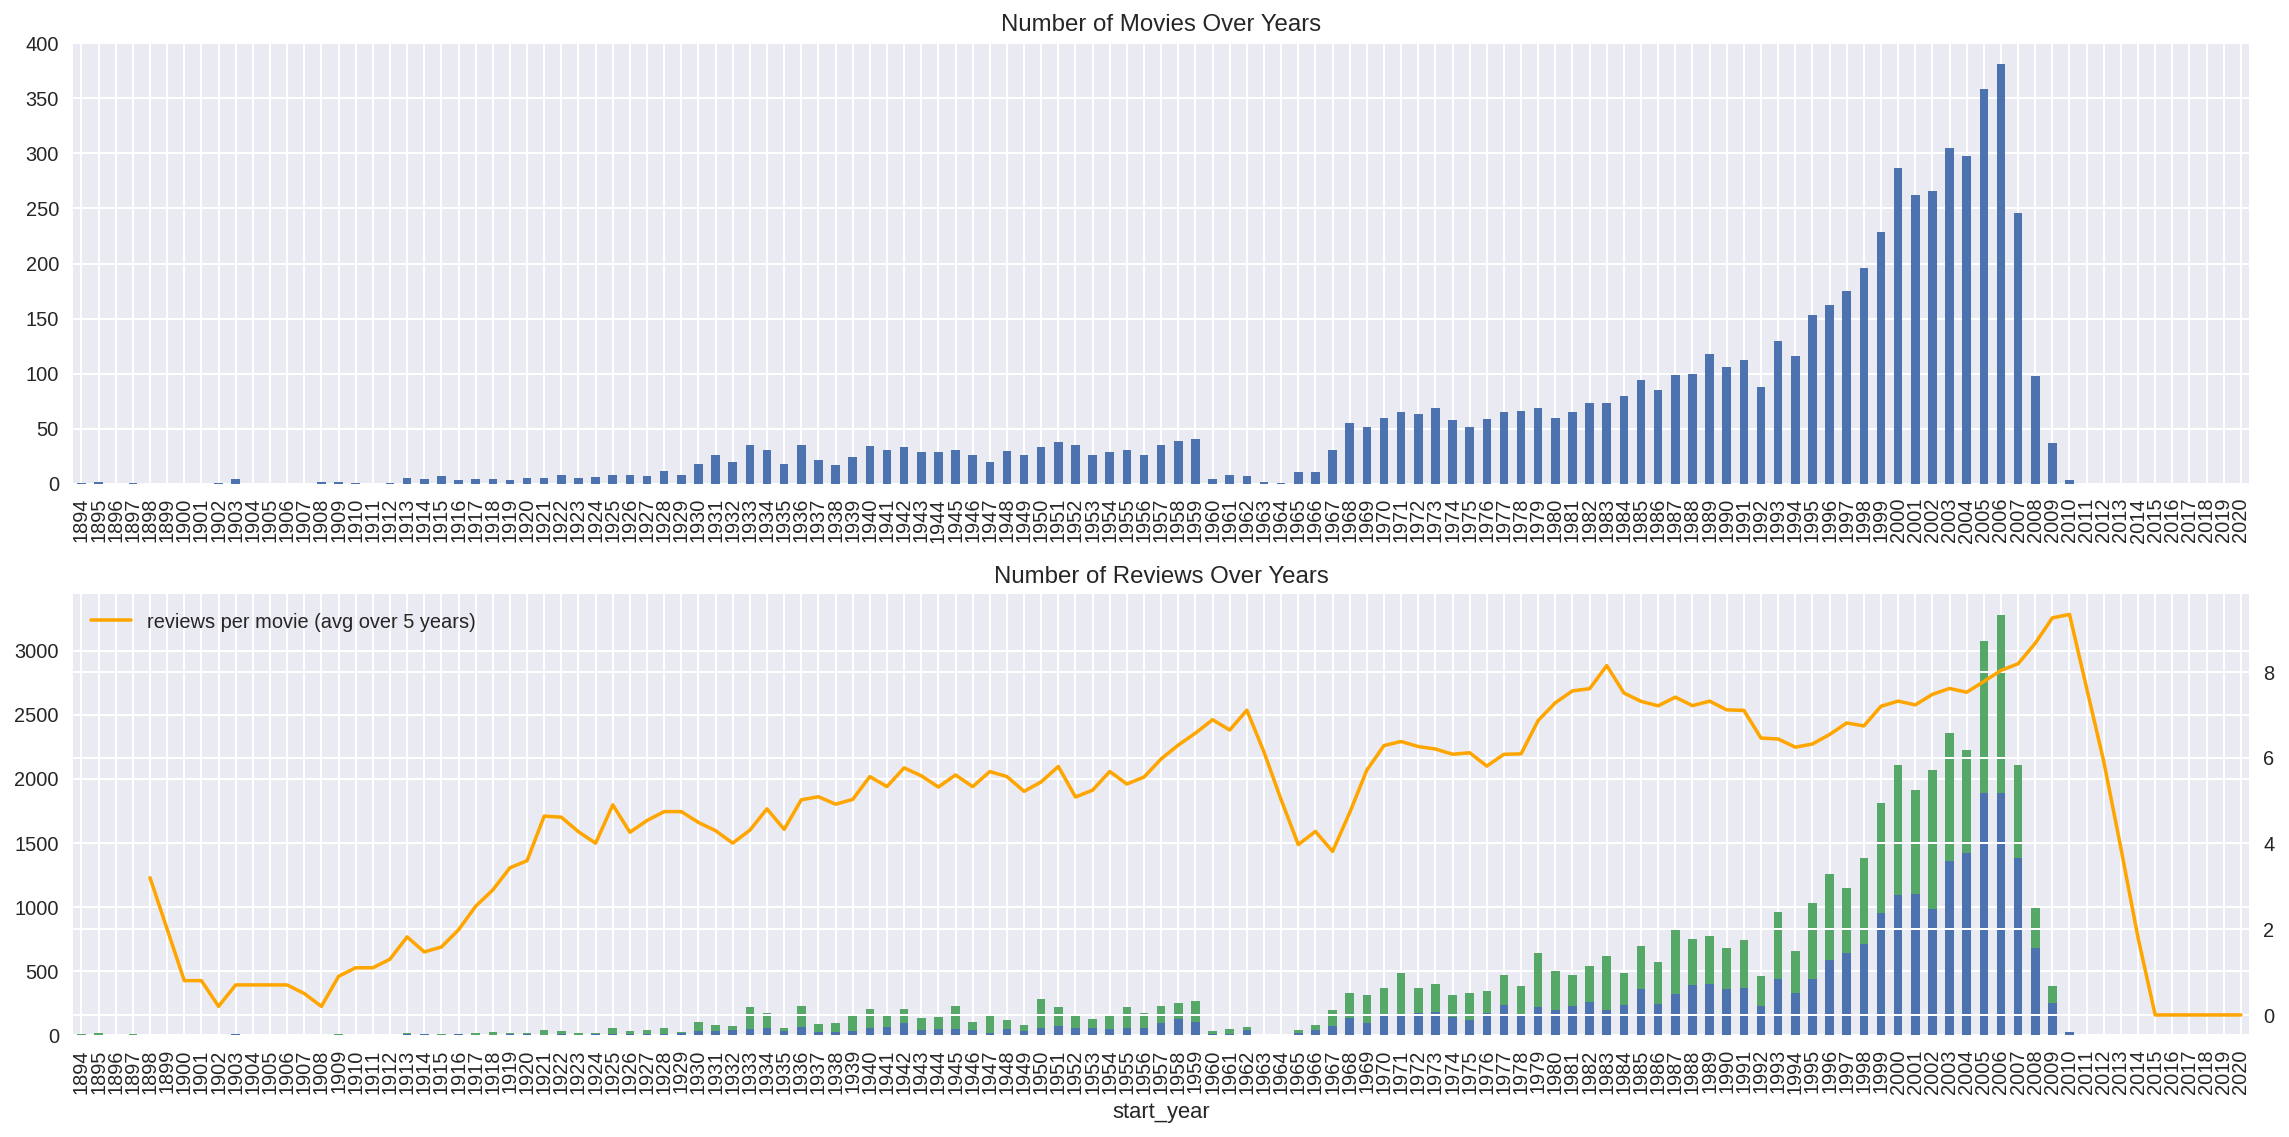

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()


Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

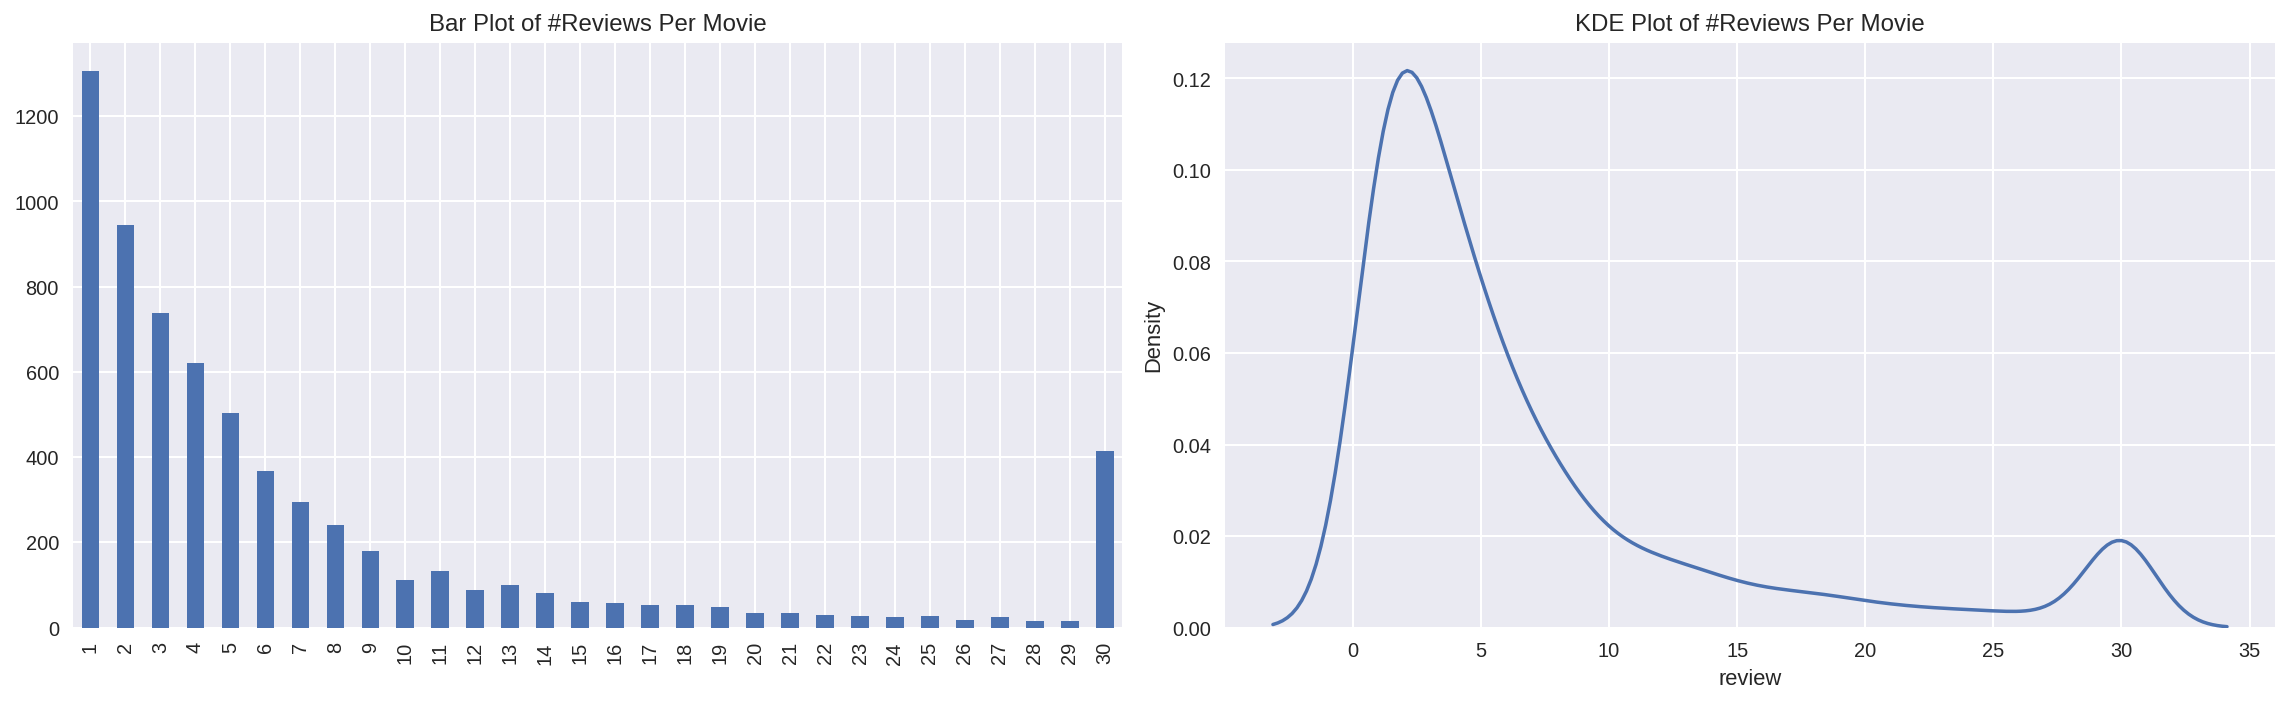

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The above plots show that the number of movies have increased over the years and the number of reviews follows a similar trend to the number of movies. It also appears that the number of reviews a movie has can vary quite significantly.

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

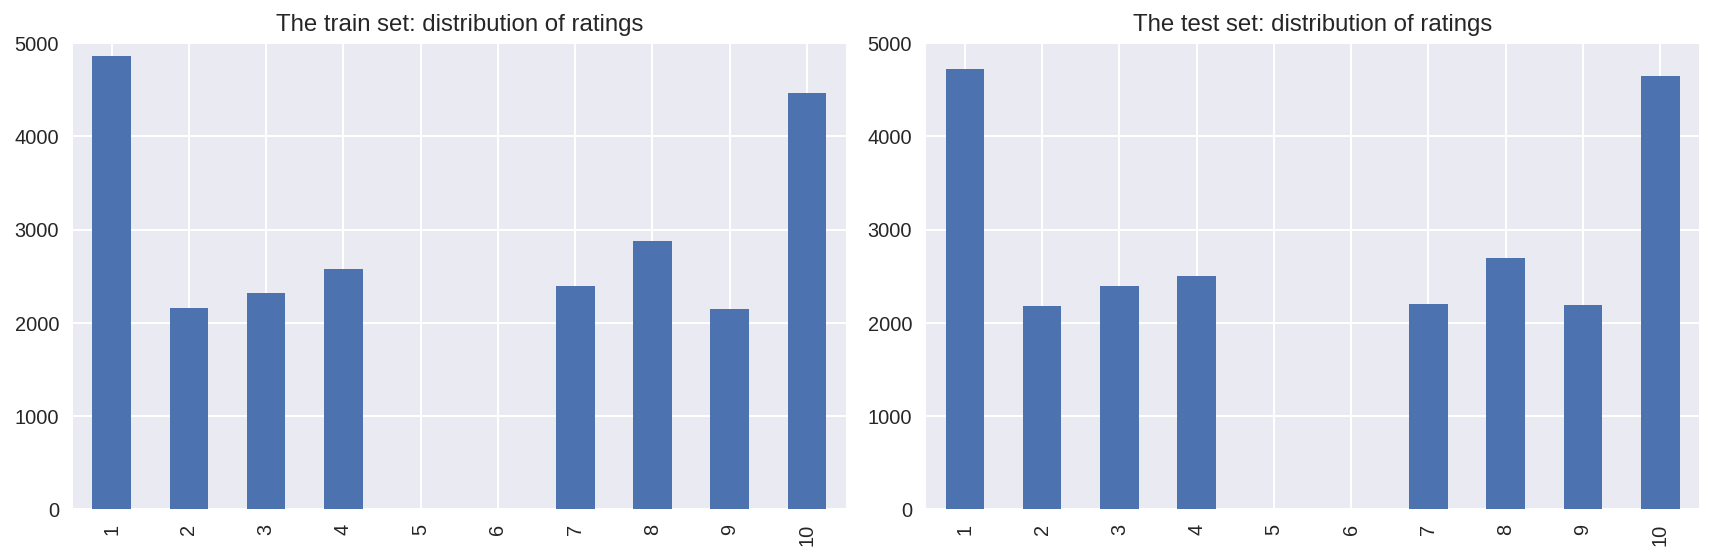

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The above analysis shows that there does not seem to be a class imbalance between the negative and positive reviews which means we do not need to address it with balancing techniques. It also appears that the distribution of ratings between the train and test set are quite similar which again indicates that we can proceed with the data without further manipulation.

Distribution of negative and positive reviews over the years for two parts of the dataset

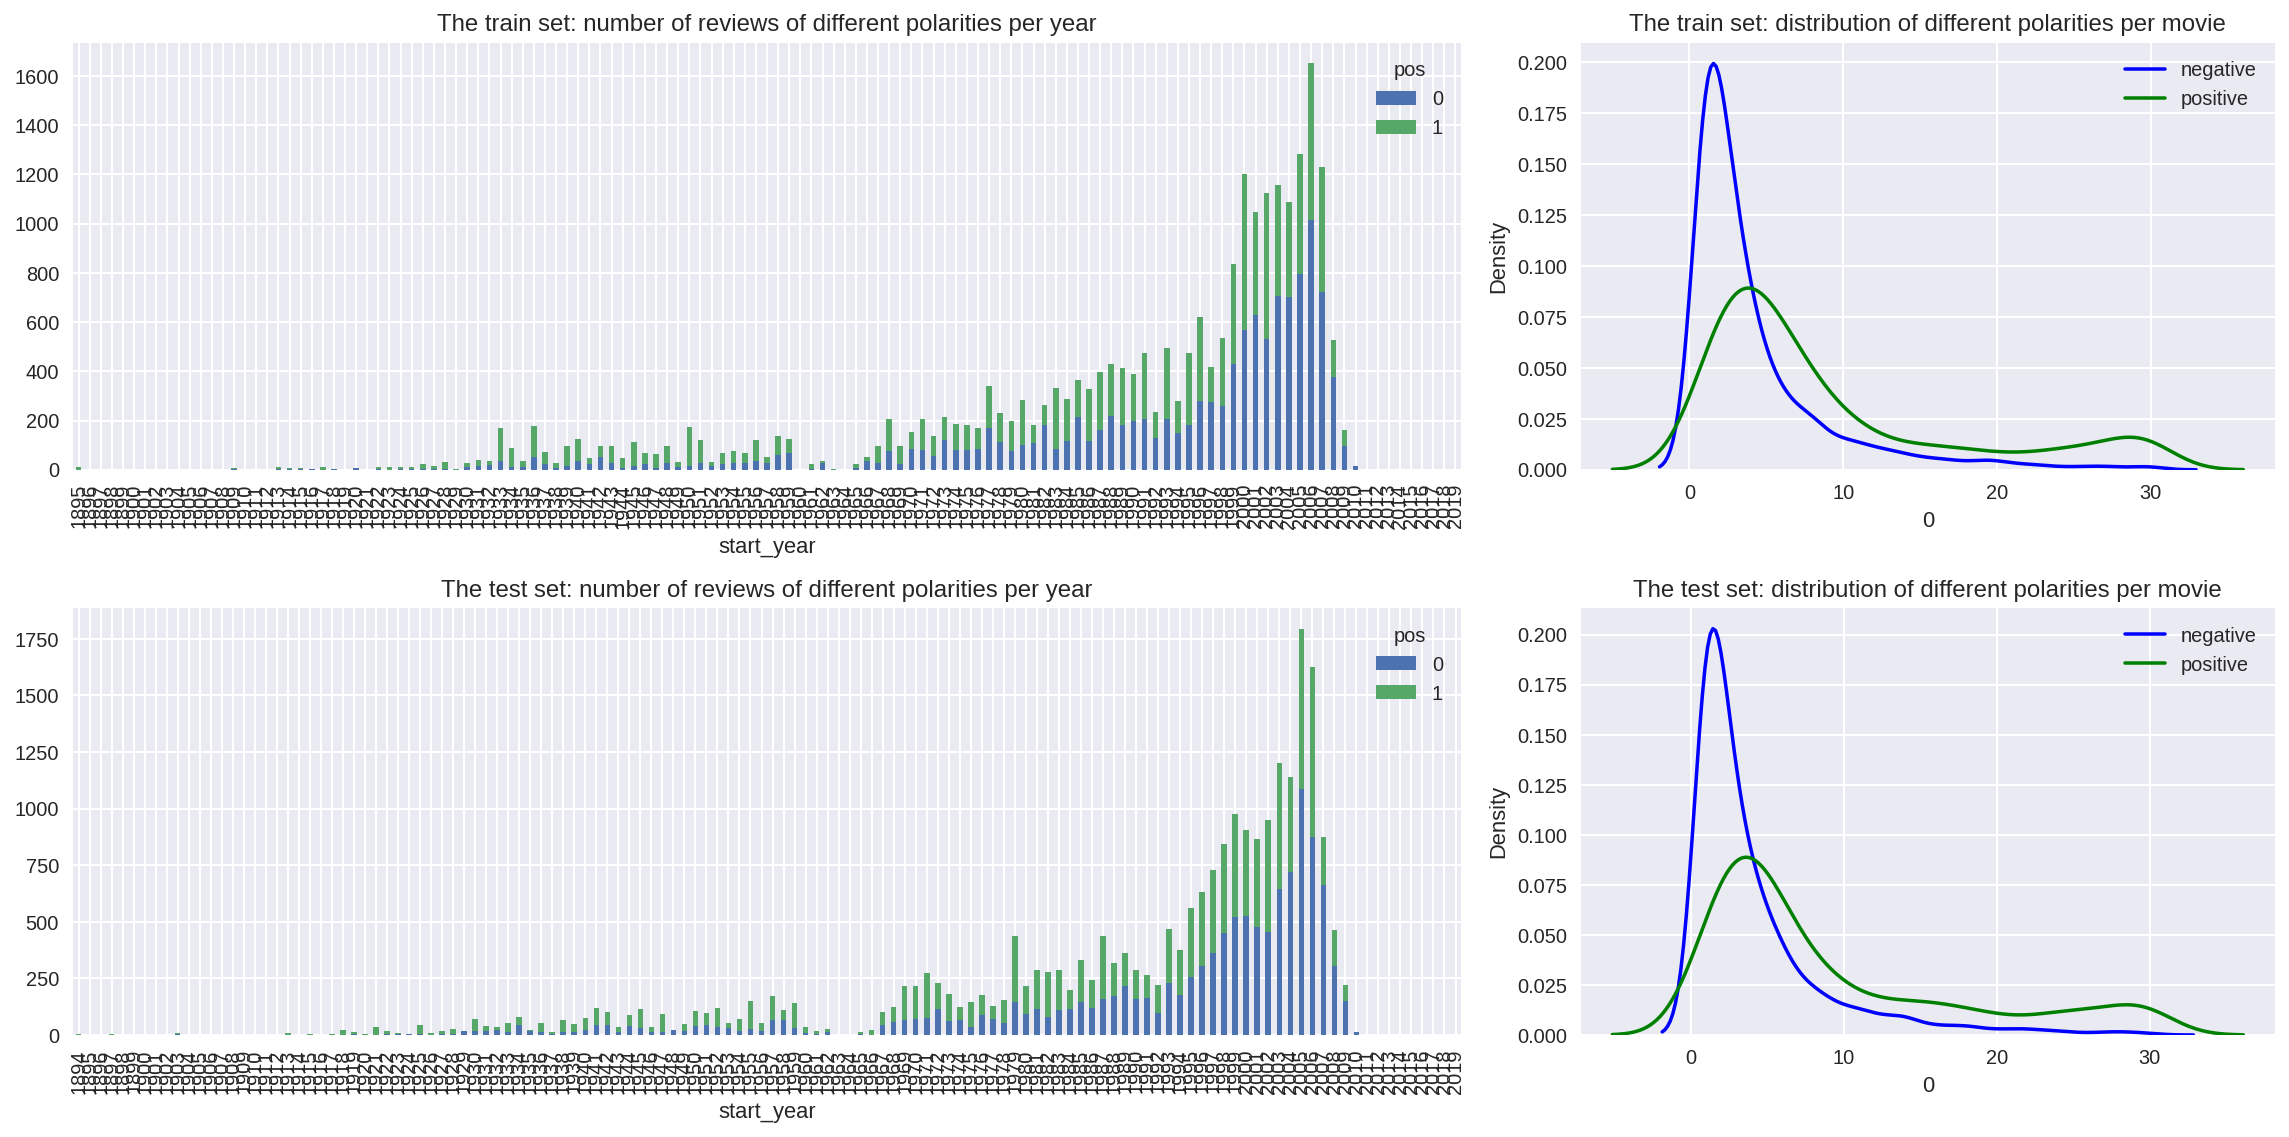

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The above plots indicate that the distribution of polarities between the train set and the test set are similar as well. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return


## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
# Import the necessary functions for normalization
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


In [14]:
# Create a lemmatization object
lemmatizer  = WordNetLemmatizer()


In [15]:
# Tokenize the "review" column
df_reviews['tokenized_reviews'] = df_reviews.apply(lambda row: word_tokenize(row['review'].lower()), axis = 1)


In [16]:
# Lemmatize the words in the 'tokenized_reviews' column
df_reviews['lemmas'] = df_reviews.apply(lambda row: [lemmatizer.lemmatize(token) for token in row['tokenized_reviews']], axis = 1)


In [17]:
# Convert the list in the 'lemmas' column into a string
df_reviews['joined_reviews'] = df_reviews.apply(lambda row: " ".join(row['lemmas']), axis = 1)


In [18]:
# Use regular expressions to remove punctuation marks and digits
df_reviews['regex_reviews'] = df_reviews.apply(lambda row: re.sub(r'[^a-z\']', ' ', row['joined_reviews']), axis = 1)
                                                                                               

In [19]:
# Use the split() function to get a list without spaces
df_reviews['split_text'] = df_reviews.apply(lambda row: row['regex_reviews'].split(), axis = 1)


In [20]:
# Use join() to combine all the elements from the split with just one space to form the final normalized reviews
df_reviews['review_norm'] = df_reviews.apply(lambda row: " ".join(row['split_text']), axis = 1)


In [21]:
# Make sure the reviews were properly normalized
df_reviews.sample(3)


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,...,sp,pos,ds_part,idx,tokenized_reviews,lemmas,joined_reviews,regex_reviews,split_text,review_norm
7471,tt0106582,movie,Cliffhanger,Cliffhanger,1993,\N,113,0,"Action,Adventure,Thriller",6.4,...,neg,0,train,3523,"[oh, ,, what, a, bad, ,, bad, ,, very, bad, mo...","[oh, ,, what, a, bad, ,, bad, ,, very, bad, mo...","oh , what a bad , bad , very bad movie ! cowri...",oh what a bad bad very bad movie cowri...,"[oh, what, a, bad, bad, very, bad, movie, cowr...",oh what a bad bad very bad movie cowritten by ...
18901,tt0087507,movie,Johnny Dangerously,Johnny Dangerously,1984,\N,90,0,"Comedy,Crime",6.6,...,pos,1,train,4700,"[i, could, not, believe, the, low, 5.6, rating...","[i, could, not, believe, the, low, 5.6, rating...",i could not believe the low 5.6 rating on imdb...,i could not believe the low rating on imdb...,"[i, could, not, believe, the, low, rating, on,...",i could not believe the low rating on imdb abo...
20418,tt0255321,movie,Liam,Liam,2000,\N,90,0,Drama,6.9,...,neg,0,train,5951,"[written, by, the, excellent, mcgovern, and, d...","[written, by, the, excellent, mcgovern, and, d...",written by the excellent mcgovern and directed...,written by the excellent mcgovern and directed...,"[written, by, the, excellent, mcgovern, and, d...",written by the excellent mcgovern and directed...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
# Delineate the train and test set
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23796, 23)
(23535, 23)


## Working with models

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


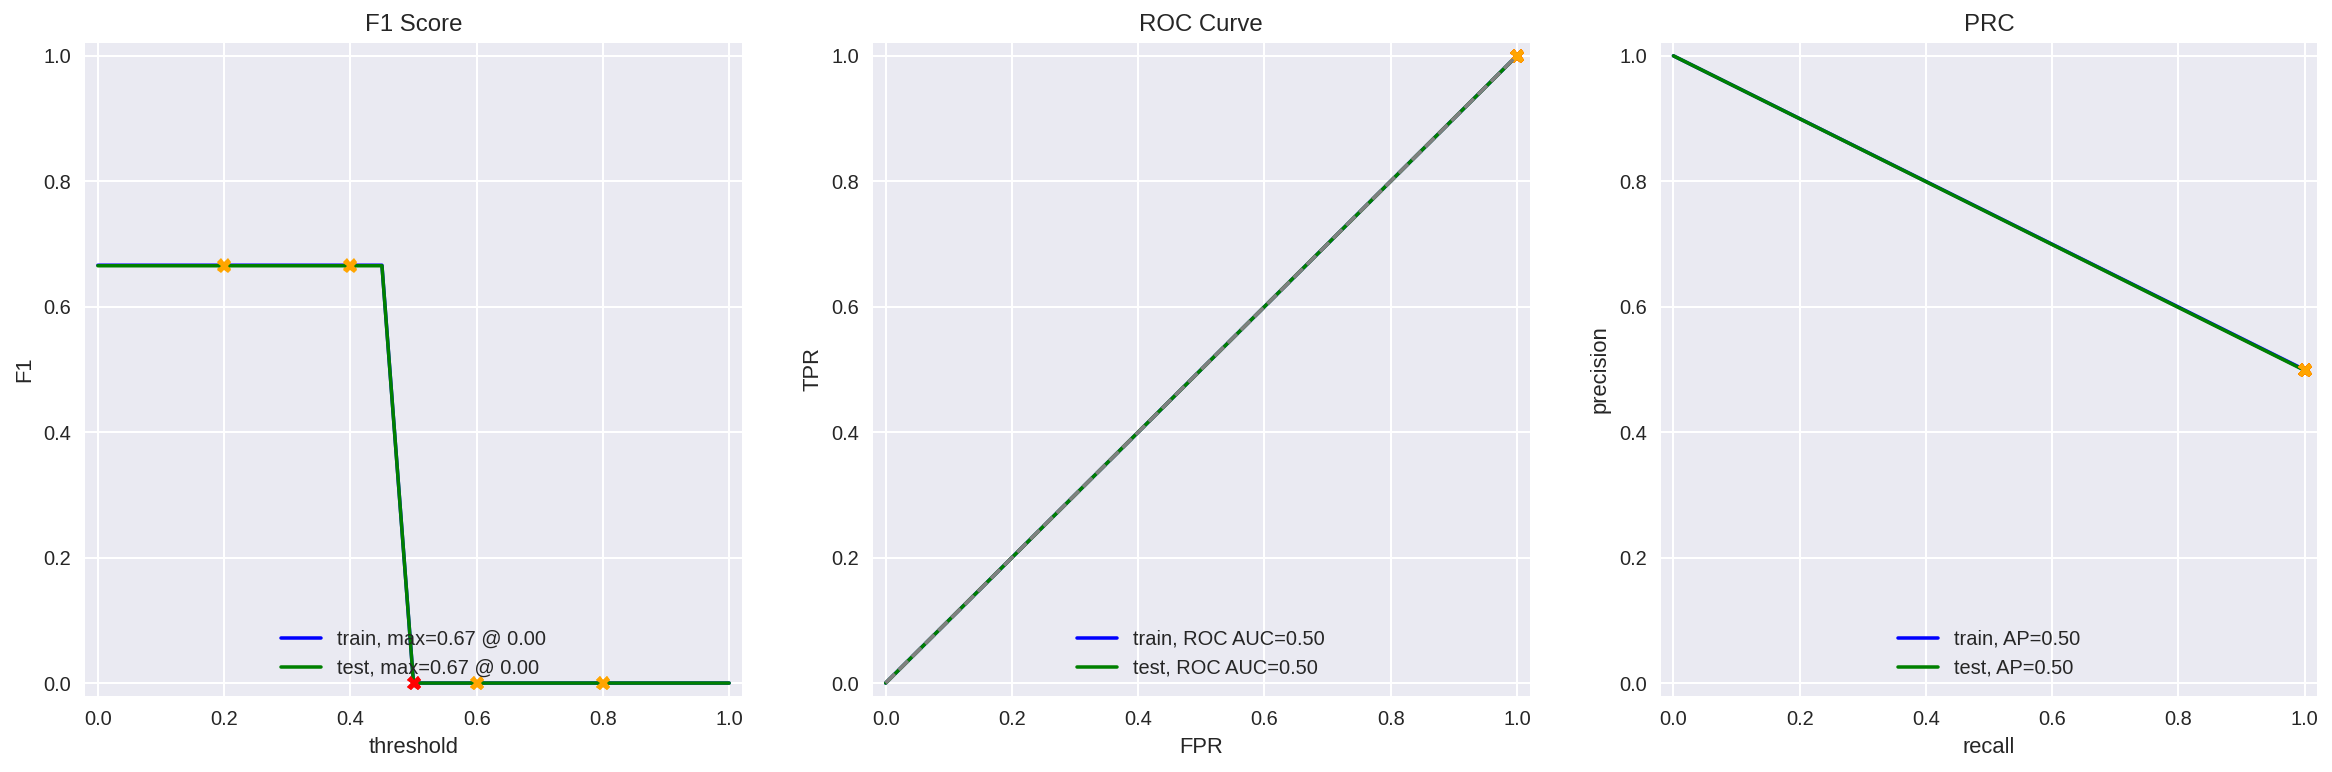

In [24]:
# Train and evaluate the DummyClassifier model
dummy = DummyClassifier()
dummy.fit(df_reviews_train, train_target)
evaluate_model(dummy, df_reviews_train, train_target, df_reviews_test, test_target)


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [25]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords


In [26]:
# Create a counter and define stop words
stop_words = set(stopwords.words('english'))
count_tf_idf_1 = TfidfVectorizer(stop_words = stop_words)


In [27]:
# Calculate tf_idf for the train and test set
reviews_train_tfidf = count_tf_idf_1.fit_transform(df_reviews_train['review_norm'])
reviews_test_tfidf = count_tf_idf_1.transform(df_reviews_test['review_norm'])


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


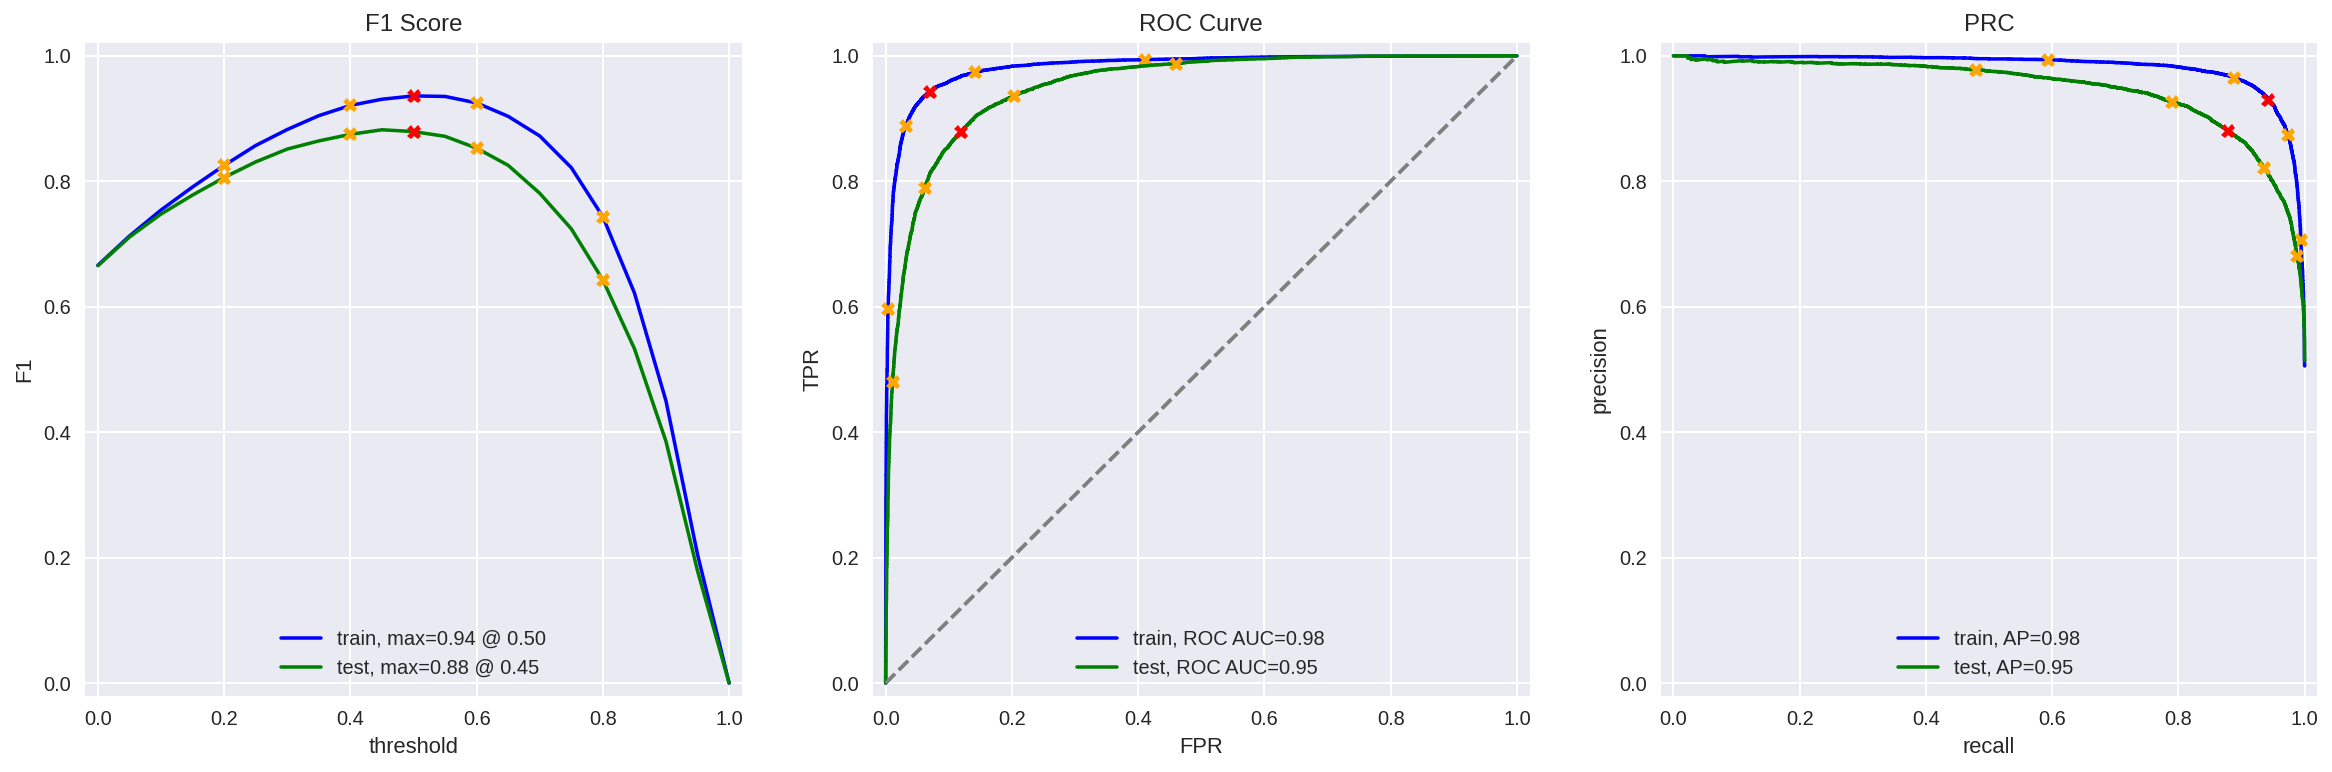

In [28]:
# Train and evaluate the Logistic Regression model
model_1 = LogisticRegression()
model_1.fit(reviews_train_tfidf, train_target)
evaluate_model(model_1, reviews_train_tfidf, train_target, reviews_test_tfidf, test_target)



### Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [30]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)


In [31]:
# Use the 'text_preprocessing_3' function to implement spacy
df_reviews_train = df_reviews_train.apply(lambda row: text_preprocessing_3(row['review_norm']), axis = 1)
df_reviews_test = df_reviews_test.apply(lambda row: text_preprocessing_3(row['review_norm']), axis = 1)


In [32]:
# Calculate tf_idf for the train and test set
count_tf_idf_3 = TfidfVectorizer(stop_words = stop_words)
reviews_train_tfidf = count_tf_idf_3.fit_transform(df_reviews_train)
reviews_test_tfidf = count_tf_idf_3.transform(df_reviews_test)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


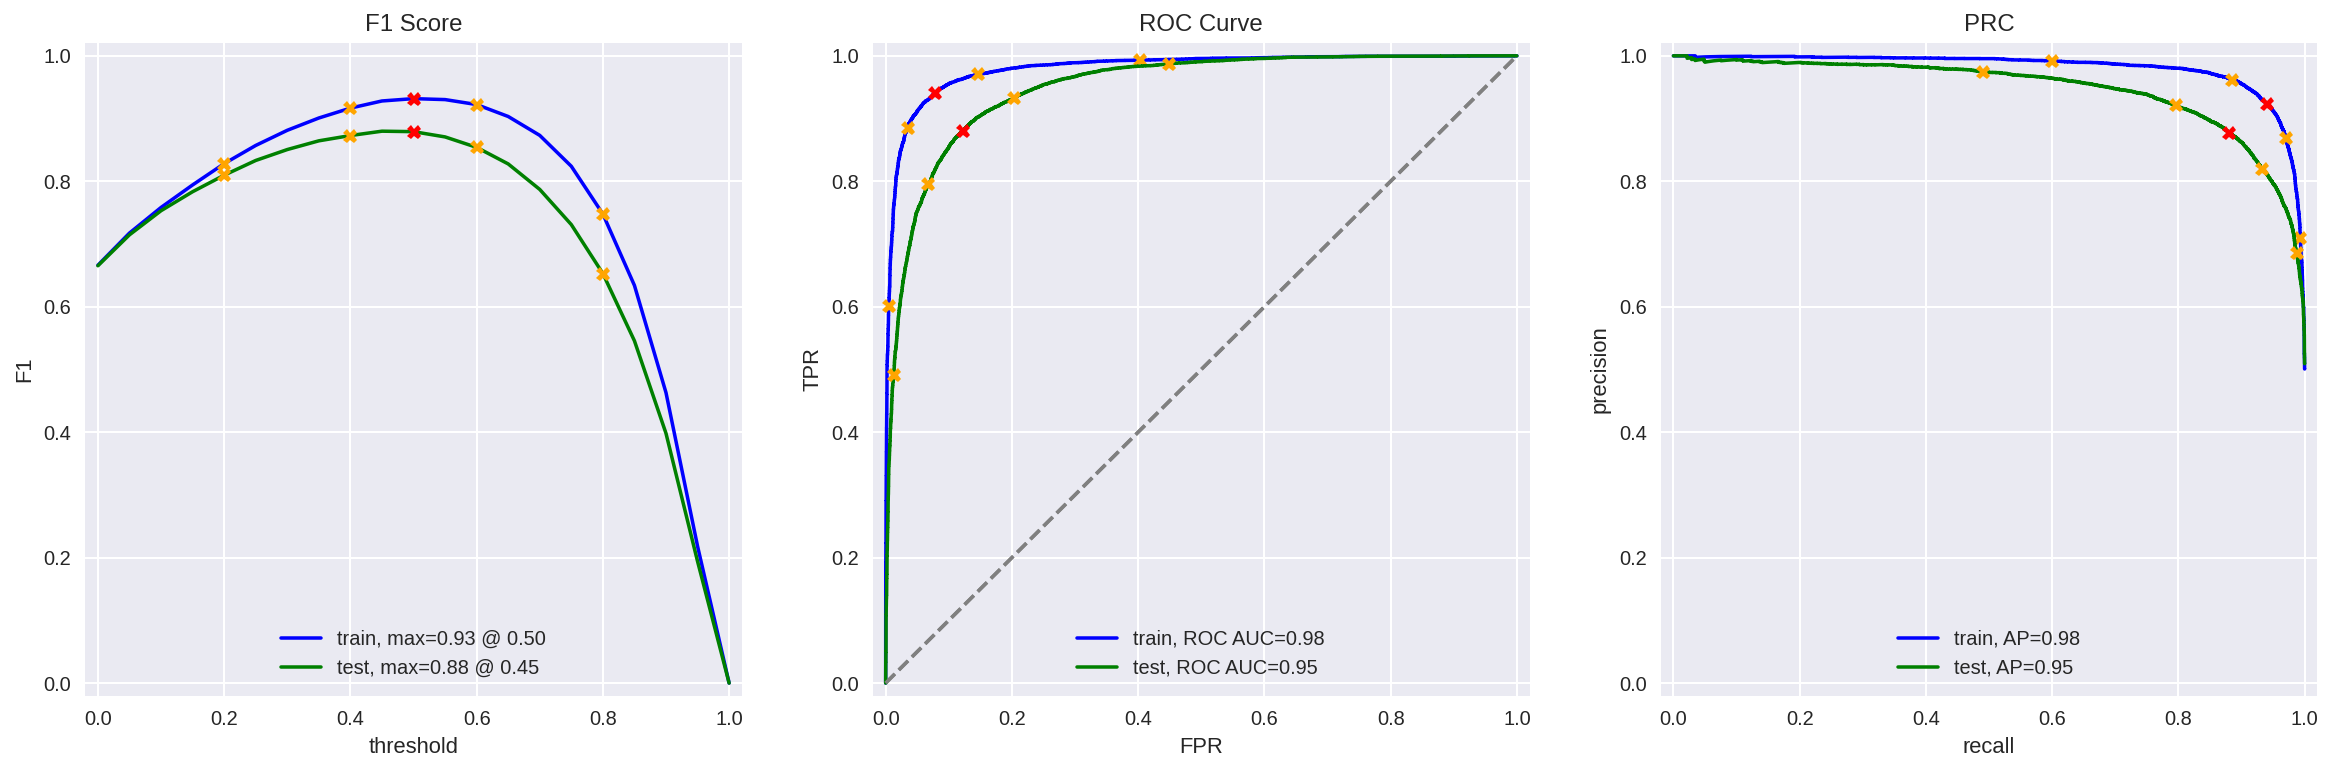

In [33]:
# Train and evaluate the Logistic Regression model
model_3 = LogisticRegression()
model_3.fit(reviews_train_tfidf, train_target)
evaluate_model(model_3, reviews_train_tfidf, train_target, reviews_test_tfidf, test_target)


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


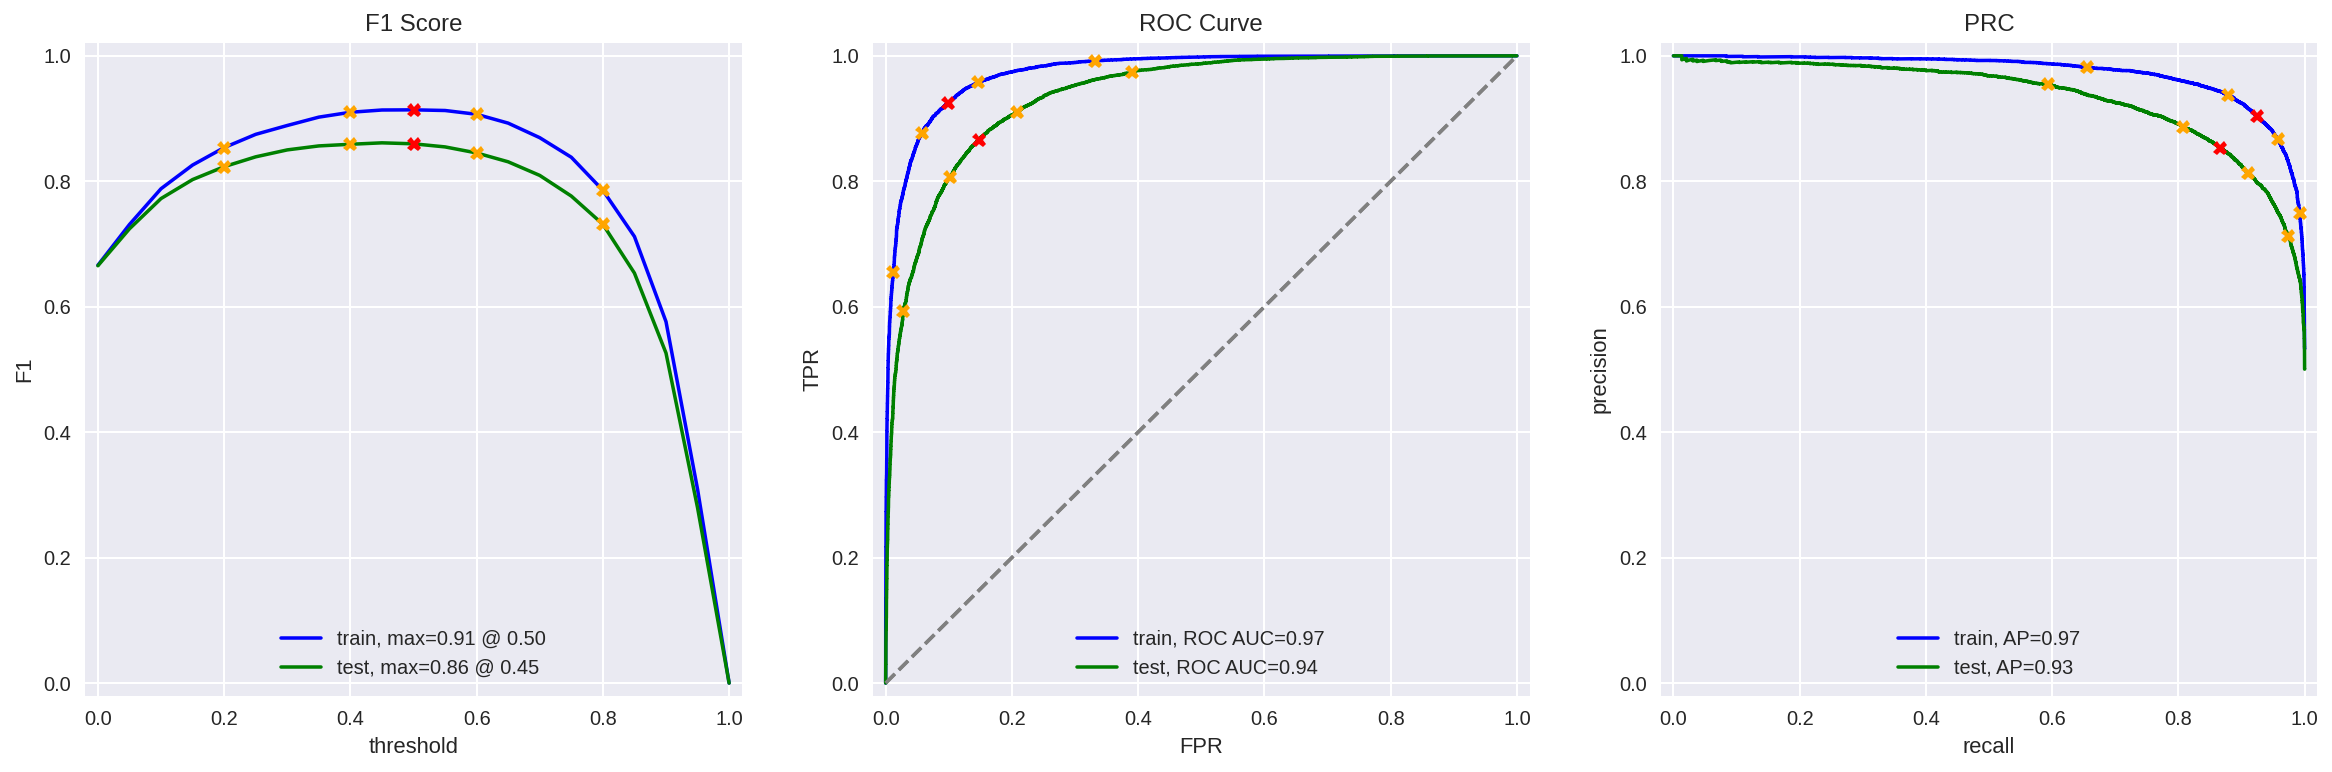

In [35]:
model_4 = LGBMClassifier(random_state = 12345)
model_4.fit(reviews_train_tfidf, train_target) # train model on training set
evaluate_model(model_4, reviews_train_tfidf, train_target, reviews_test_tfidf, test_target)


###  Model 9 - BERT (unused)

In [36]:
# import torch
# import transformers

In [37]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [38]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
    
#     # <put your code here to create ids_list and attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # gettings embeddings in batches

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <put your code here to create attention_mask_batch
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [39]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [40]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [41]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [42]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['tokenized_reviews'] = my_reviews.apply(lambda row: word_tokenize(row['review'].lower()), axis = 1)
my_reviews['lemmas'] = my_reviews.apply(lambda row: [lemmatizer.lemmatize(token) for token in row['tokenized_reviews']], axis = 1)
my_reviews['joined_reviews'] = my_reviews.apply(lambda row: " ".join(row['lemmas']), axis = 1)
my_reviews['regex_reviews'] = my_reviews.apply(lambda row: re.sub(r'[^a-z\']', ' ', row['joined_reviews']), axis = 1)
my_reviews['split_text'] = my_reviews.apply(lambda row: row['regex_reviews'].split(), axis = 1)
my_reviews['review_norm'] = my_reviews.apply(lambda row: " ".join(row['split_text']), axis = 1)

my_reviews.sample(3)


,review,tokenized_reviews,lemmas,joined_reviews,regex_reviews,split_text,review_norm
0,"I did not simply like it, not my kind of movie.","[i, did, not, simply, like, it, ,, not, my, ki...","[i, did, not, simply, like, it, ,, not, my, ki...","i did not simply like it , not my kind of movie .",i did not simply like it not my kind of movie,"[i, did, not, simply, like, it, not, my, kind,...",i did not simply like it not my kind of movie
6,What a rotten attempt at a comedy. Not a singl...,"[what, a, rotten, attempt, at, a, comedy, ., n...","[what, a, rotten, attempt, at, a, comedy, ., n...",what a rotten attempt at a comedy . not a sing...,what a rotten attempt at a comedy not a sing...,"[what, a, rotten, attempt, at, a, comedy, not,...",what a rotten attempt at a comedy not a single...
4,I didn't expect the reboot to be so good! Writ...,"[i, did, n't, expect, the, reboot, to, be, so,...","[i, did, n't, expect, the, reboot, to, be, so,...",i did n't expect the reboot to be so good ! wr...,i did n't expect the reboot to be so good wr...,"[i, did, n't, expect, the, reboot, to, be, so,...",i did n't expect the reboot to be so good writ...


### Model 1

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]
# pred_target = model.predict(features)
# pred_proba = model.predict_proba(features)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.16:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.46:  i wa really fascinated with the movie
0.12:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.30:  i did n't expect the reboot to be so good writer really cared about the source material
0.53:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 3

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.21:  i did not simply like it not my kind of movie
0.11:  well i wa bored and felt asleep in the middle of the movie
0.42:  i wa really fascinated with the movie
0.10:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.29:  i did n't expect the reboot to be so good writer really cared about the source material
0.54:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.92:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 4

In [45]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    

0.63:  i did not simply like it not my kind of movie
0.32:  well i wa bored and felt asleep in the middle of the movie
0.52:  i wa really fascinated with the movie
0.38:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.74:  i did n't expect the reboot to be so good writer really cared about the source material
0.69:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.31:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.72:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 9 (unused)

In [46]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

The following are the F1 scores from the model testing:

-Model 0 (Dummy): 0.0 (train), 0.0 (test)

-Model 1 (NLTK, TF-IDF and LR): 0.94 (train), 0.88 (test)

-Model 3 (spaCy, TF-IDF and LR): 0.93 (train), 0.88 (test)

-Model 4 (spaCy, TF-IDF and LGBMClassifier): 0.91 (train), 0.86 (test)

These results indicate that Model 1 (NLTK, TF-IDF and LR) and Model 3 (spaCy, TF-IDF and LR) produced the highest, and thus the best, scores for the test set. This inplies that Logistic Regression was the most successful and that there is not much of a difference between the utilization of NLTK versus spaCy for the analysis. Model 4 also performed similarly, just with a slightly lower F1 score than the other two models.

The results of the test case reviews (based on the assumption that values of 0-0.5 indicate a negative review while the values of 0.51-1 indicate a postive review) are the following:

-Model 1 (NLTK, TF-IDF and LR): 6/8 accurate classifications

-Model 3 (spaCy, TF-IDF and LR): 6/8 accurate classifications

-Model 4 (spaCy, TF-IDF and LGBMClassifier): 7/8 accurate classifications

The results above show a similar level of accuracy in terms of classifying the reviews with Model 4 performing just a little better than Model 1 and 3.

# Checklist

- [x]  Notebook was opened
- [X]  The text data is loaded and pre-processed for vectorization
- [X]  The text data is transformed to vectors
- [X]  Models are trained and tested
- [X]  The metric's threshold is reached
- [X]  All the code cells are arranged in the order of their execution
- [X]  All the code cells can be executed without errors
- [x]  There are conclusions